In [1]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [3]:
def nencioli(u, v, lon, lat, a, b): #,var
    """
    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """
    borders = max(a, b) + 1
    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)
    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))
    # Get domain dimensions
    bound = vel.shape
    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v
        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]
        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1
            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0
                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))
                    i1, i2 = int(i1[0]), int(i2[0])
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])
                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])
    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)
    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

In [4]:
def vis(eddy, t, depth_lvl):

    U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']
    X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
    var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
    xc_pre, yc_pre = 0, 0

    # Find nencioli
    u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
    neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
    neddy = neddy[neddy[:, 2] == var]
    
    if len(neddy[:, 1]) > 1:
        R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
        neddy = neddy[R == np.nanmin(R)]
    # elif len(neddy[:, 1]) == 0:
    #     break
    
    nxc, nyc = neddy[0, 1], neddy[0, 0]
    nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]
    
    # Fit cubic and tangent
    def fit_cubic_and_tangent(x, y):
        cubic = np.poly1d(np.polyfit(x, y, 3))
        cubic_deriv = np.polyder(cubic)
        roots = np.roots(cubic)
        valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
    
        if valid_roots.size:
            R = np.abs(valid_roots-x[len(x)//2])
            root = valid_roots[R==np.min(R)][0]
            slope = cubic_deriv(root)
            intercept = -slope * root
        else:
            slope = 0
            roots = np.roots(cubic_deriv)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)]
                intercept = cubic(root)
            else:
                intercept = np.mean(y)

        sst = np.sum((y - np.mean(y))**2)
        sse = np.sum((y - cubic(x))**2)  # Use cubic(x) instead of tangent_line

        r_squared = 1 if (sst == 0 and sse == 0) else 1 - (sse / sst)
            
        return slope, intercept, r_squared

    def optimal_cubic_domain(l, vel, ic, r_min=20, r_max=40):

        def min_distance_from_index_to_nan_1d(arr, ic):
            from scipy.ndimage import distance_transform_edt
            mask = np.isnan(arr)
            distances = distance_transform_edt(~mask)
            return distances[ic] - 1
            
        r_compulsory_min = min_distance_from_index_to_nan_1d(vel, ic)

        if r_compulsory_min < r_min:
            return None, None, None, None, None

        results = []
    
        for r1 in range(r_min, r_max + 1):
            for r2 in range(r_min, r_max + 1):
                i_min, i_max = max(0, ic - r1), min(len(vel), ic + r2 + 1)
    
                vel_cut = vel[i_min:i_max]
                l_cut = l[i_min:i_max]
                if np.any(np.isnan(vel_cut)): # another r will work
                    E1, E0, r2E = np.nan, np.nan, np.nan
                else:
                    mask = ~np.isnan(vel_cut)
                    vel_cut = vel_cut[mask]
                    l_cut = l_cut[mask] / 1000

                    E1, E0, r2E = fit_cubic_and_tangent(l_cut, vel_cut)
        
                results.append((r1, r2, E1, E0, r2E))
    
        df = pd.DataFrame(results, columns=['r1', 'r2', 'Slope', 'Int', 'R2'])

        if df.isna().all().all():
            return None, None, None, None, None
    
        optimal_domain = df.loc[df['R2']==np.nanmax(df['R2'])].iloc[-1]

        return optimal_domain['Slope'], optimal_domain['Int'], optimal_domain['R2'], optimal_domain['r1'], optimal_domain['r2']


    u1, v1 = u[:, njc], v[:, njc]
    u2, v2 = u[nic, :], v[nic, :]

    B1, B0, r2B, r1, r2 = optimal_cubic_domain(x, v1, nic)
    C1, C0, r2C, r3, r4 = optimal_cubic_domain(y, u2, njc)

    i_min, i_max = int(max(0, nic - r1)), int(min(len(u1), nic + r2))
    u1, v1 = u1[i_min:i_max], v1[i_min:i_max]
    xx = x[i_min:i_max]/1000
    A1, A0, r2A = fit_cubic_and_tangent(xx, u1)

    j_min, j_max = int(max(0, njc - r3)), int(min(len(u2), njc + r4))
    u2, v2 = u2[j_min:j_max], v2[j_min:j_max]
    yy = y[j_min:j_max]/1000
    D1, D0, r2D = fit_cubic_and_tangent(yy, v2)

    fig, axs = plt.subplots(1, 4, figsize=(28, 7))
    datasets = [(xx, u1, 'u1'),
                (xx, v1, 'v1'),
                (yy, u2, 'u2'),
                (yy, v2, 'v2')]
    
    for ax, (l, vel, label) in zip(axs, datasets):
        slope, intercept, R2 = fit_cubic_and_tangent(l, vel)
        l_fine = np.linspace(l.min(), l.max(), 500)
        ax.plot(l, vel, 'o', label=f'Original {label} data')
        ax.plot(l_fine, np.poly1d(np.polyfit(l, vel, 3))(l_fine), '-', label=f'Cubic fit for {label}')
        ax.plot(l_fine, slope * l_fine + intercept, '--', label=f'R2={R2:.2f}')
        ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=.5)
        ax.set_xlabel('x' if '1' in label else 'y')
        ax.set_ylabel(label)
        ax.legend()
    plt.tight_layout()
    plt.show()

    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                
    yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
    xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
    w = 2 * (q11 + q22)

    # Plot results
    spacing = 5
    plt.quiver(X[::spacing, ::spacing]/1000, Y[::spacing, ::spacing]/1000, u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)

    plt.plot(xx, [nyc/1000] *len(xx), 'r', zorder=1, alpha=.5)
    plt.plot([nxc/1000] * len(yy), yy, 'r', zorder=1, alpha=.5)

    if np.any(np.isnan(u)):
        nan_mask = np.isnan(u)
        mask = np.where(~np.isnan(u), np.nan, 0)
        plt.contourf(X/1000, Y/1000, mask.T, cmap='gray', zorder=-1)
        plt.contour(X/1000, Y/1000, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    # plt.scatter(nxc/1000, nyc/1000, color='k', marker='x', label='Nenc')
    plt.scatter(xc/1000, yc/1000, color='r', marker='x', s=100, label='MOCA')
    plt.legend()

    print(f'r1={r1*dx/1000}km, r2={r2*dx/1000}km, r3={r3*dx/1000}km, r4={r4*dx/1000}km')


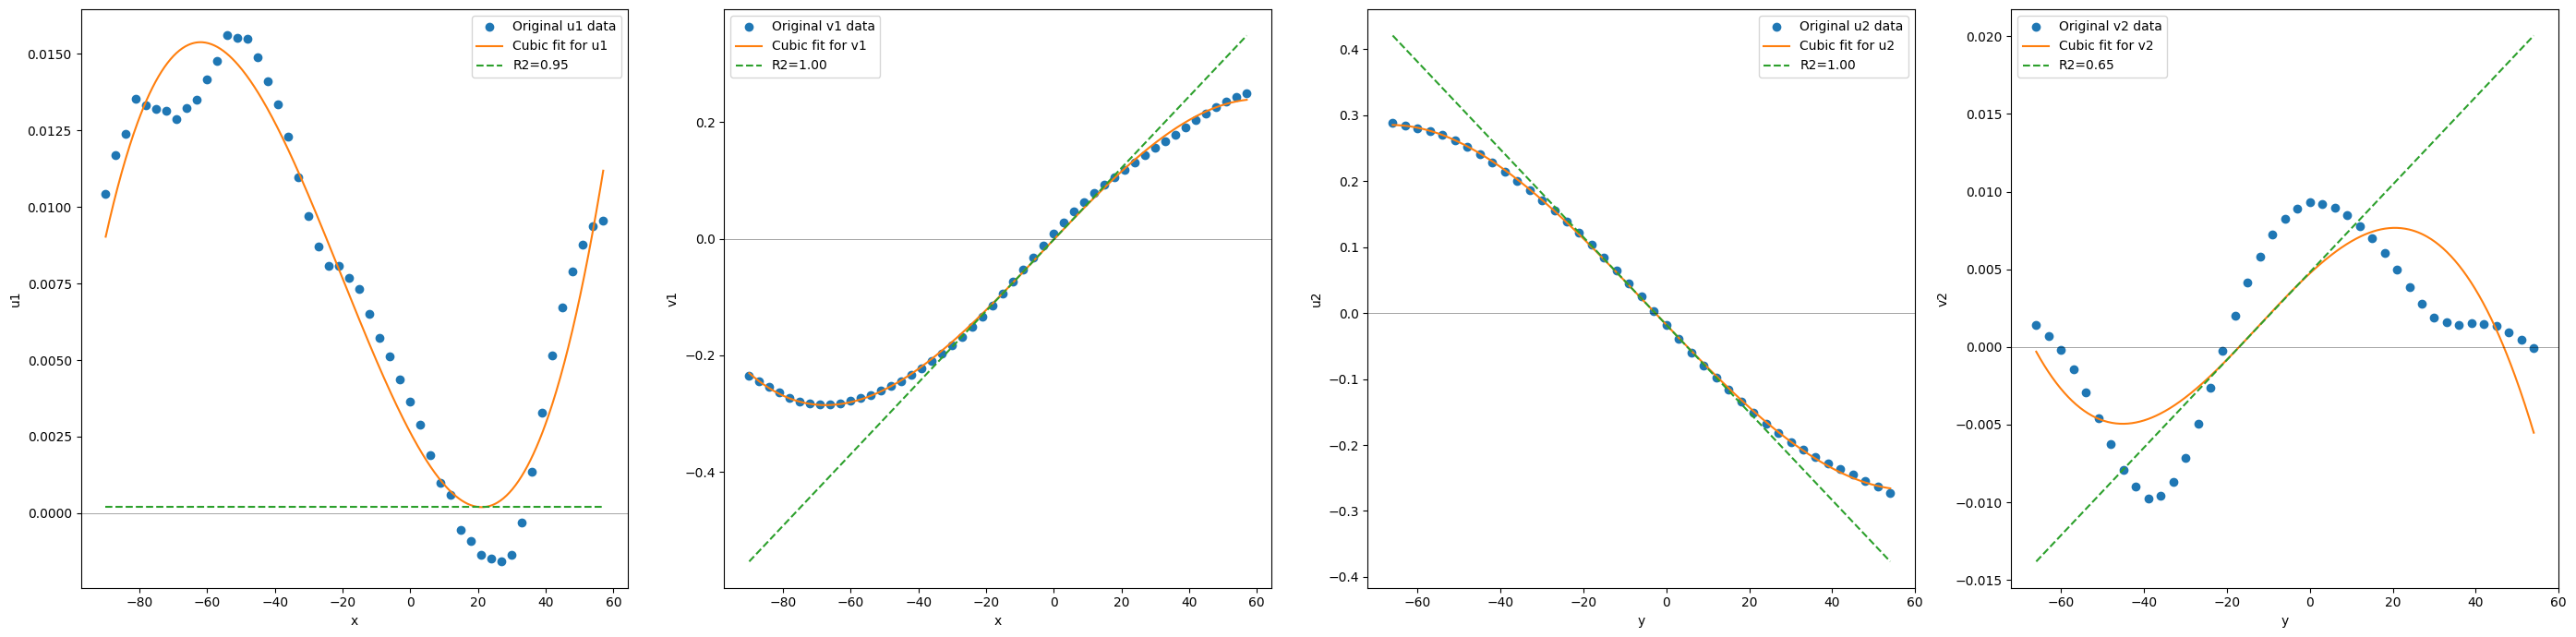

r1=90.0km, r2=60.0km, r3=63.0km, r4=60.0km


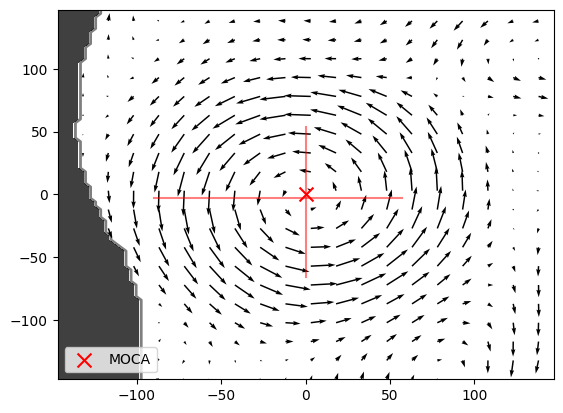

In [5]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 14, 20

vis(eddy, t, depth_lvl)

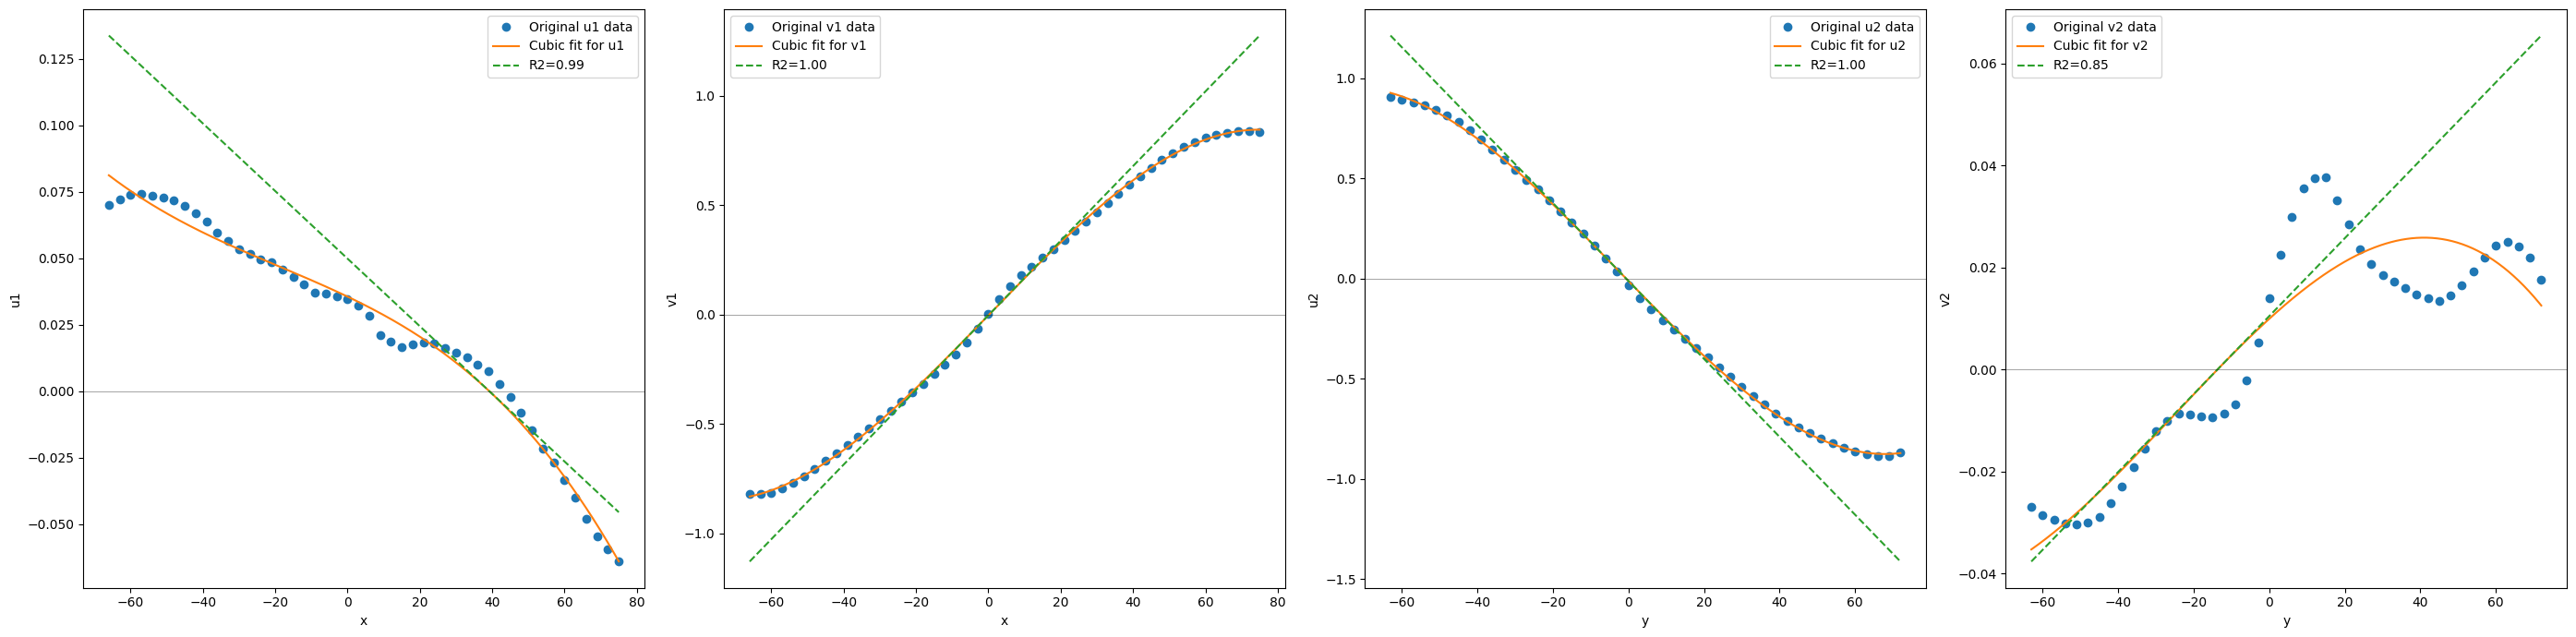

r1=66.0km, r2=78.0km, r3=60.0km, r4=78.0km


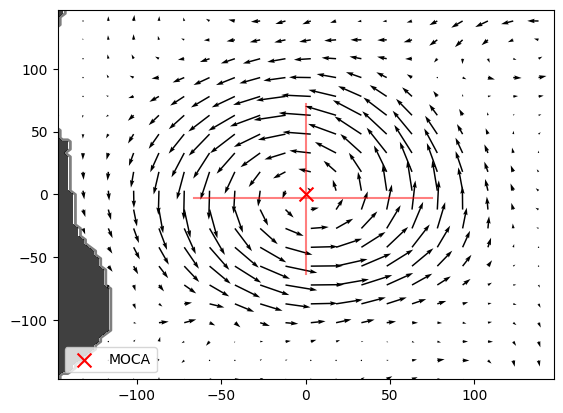

In [6]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 25, 10

vis(eddy, t, depth_lvl)

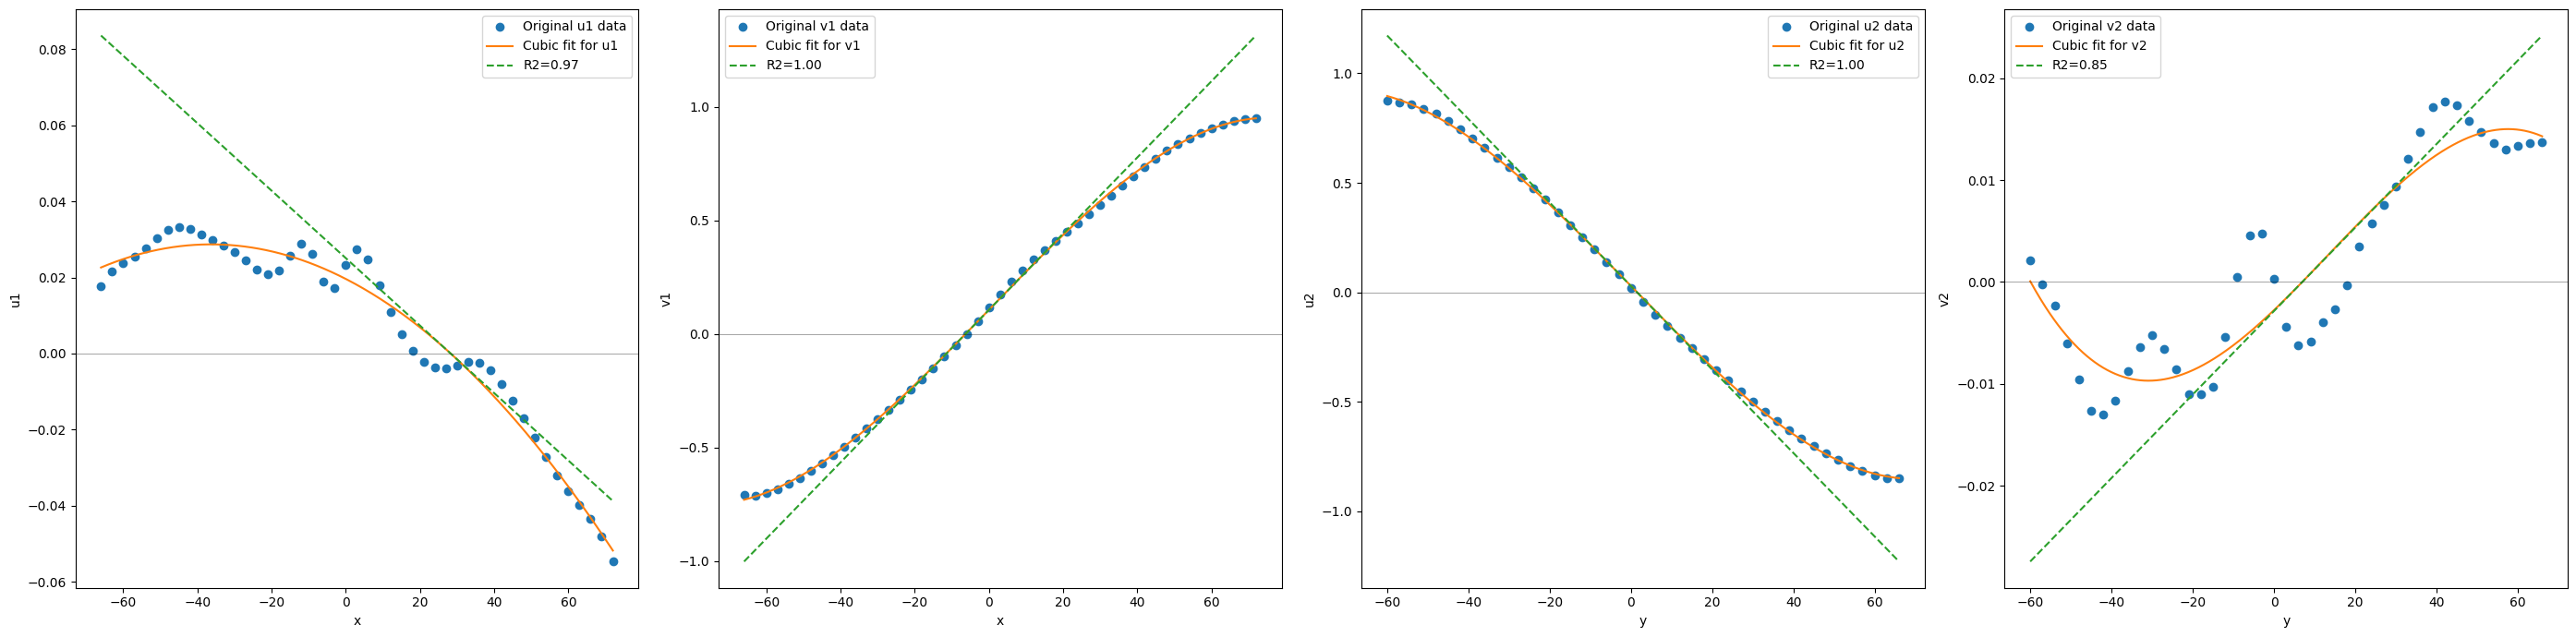

r1=60.0km, r2=81.0km, r3=60.0km, r4=69.0km


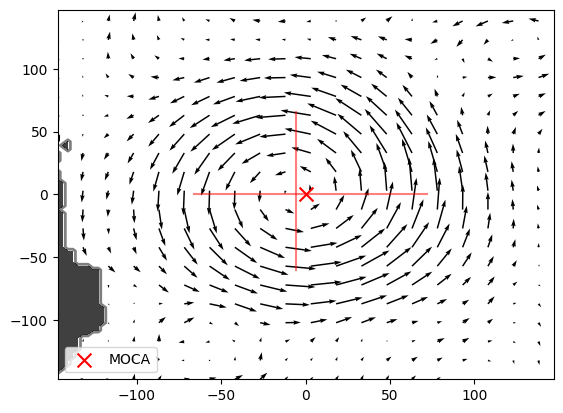

In [7]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 25, 0

vis(eddy, t, depth_lvl)

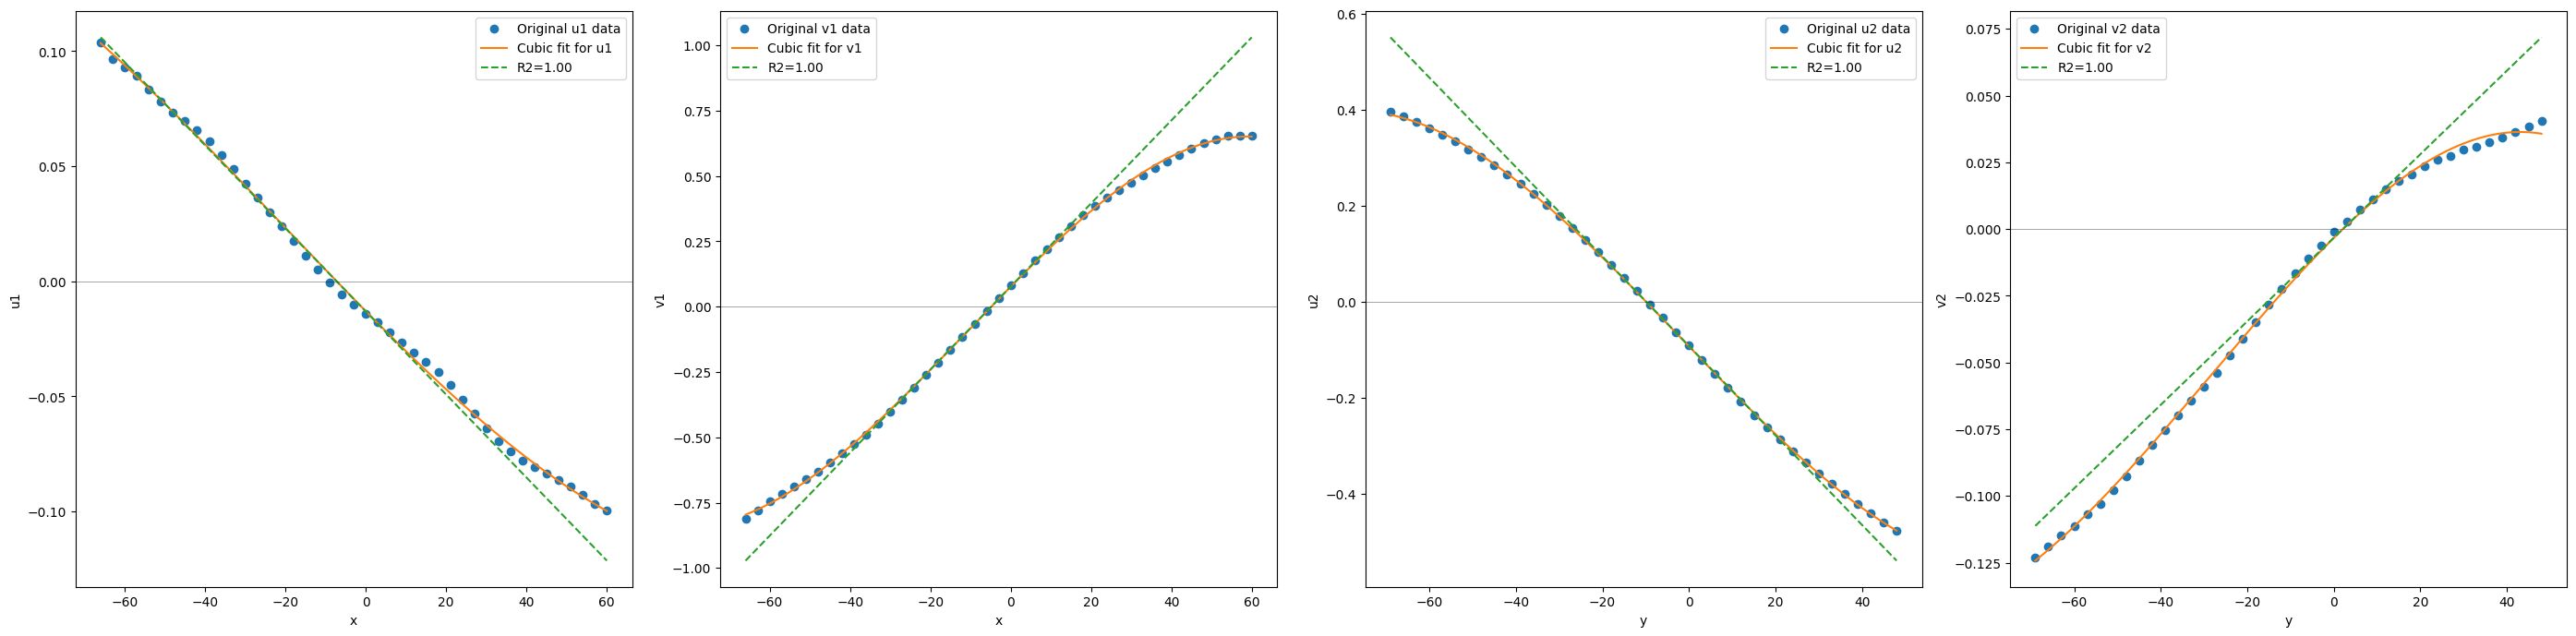

r1=60.0km, r2=69.0km, r3=60.0km, r4=60.0km


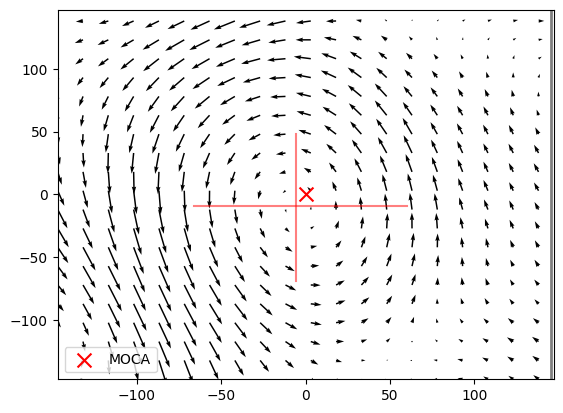

In [8]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 0, 10

vis(eddy, t, depth_lvl)

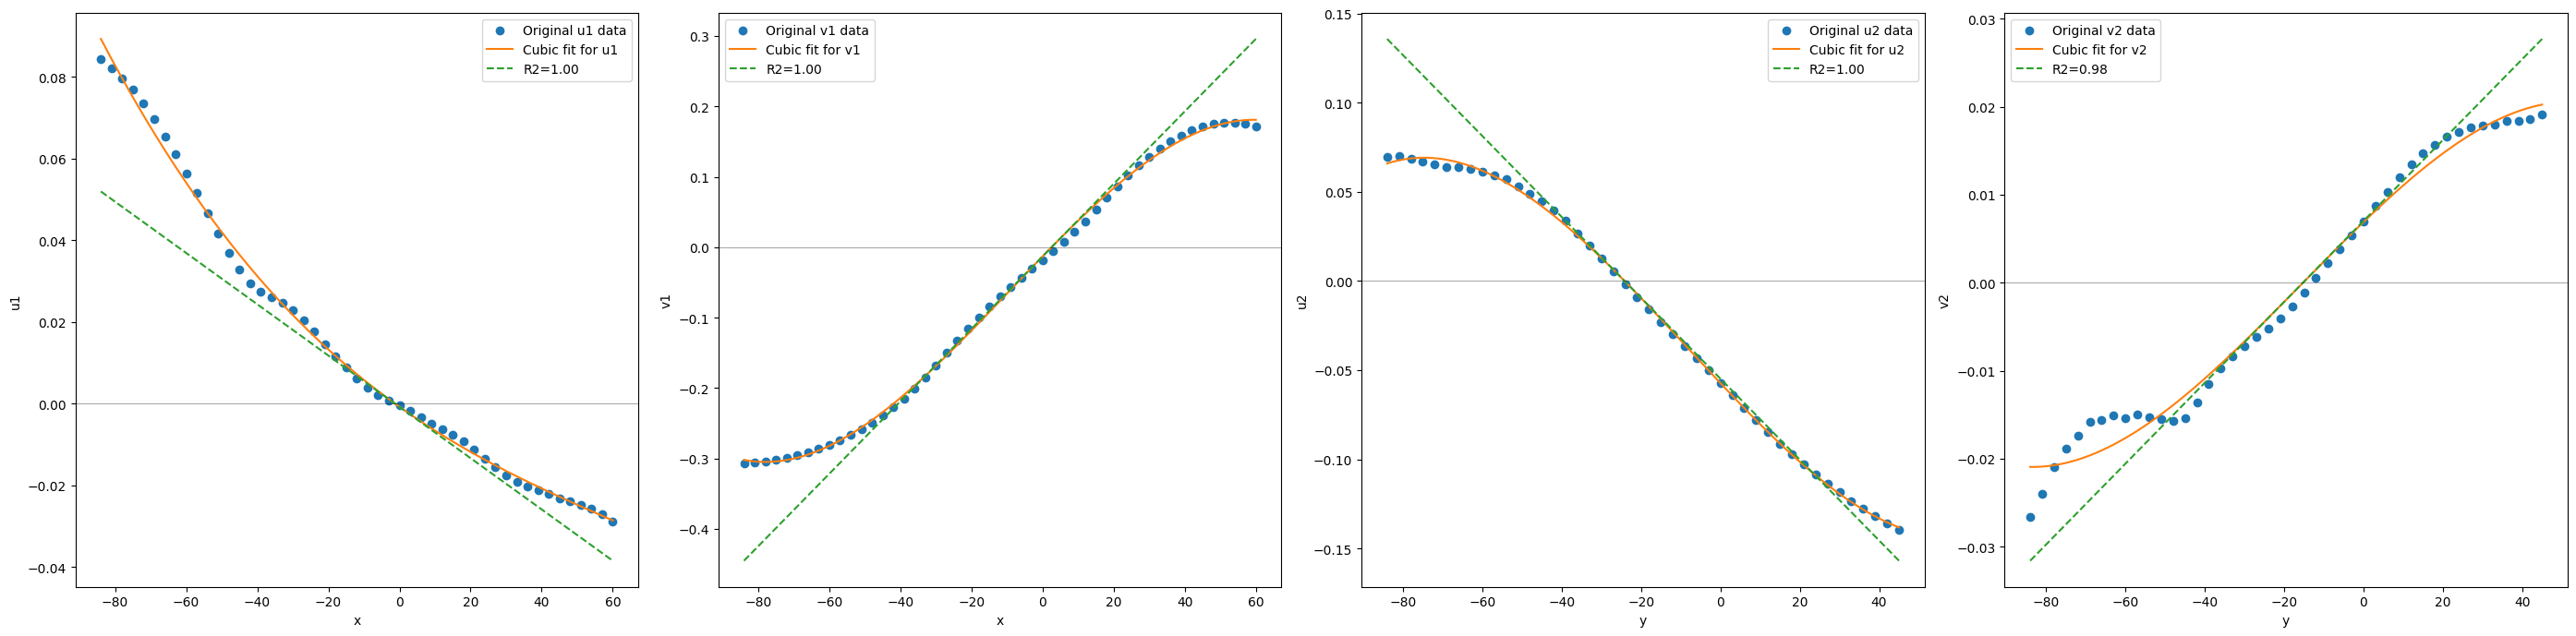

r1=87.0km, r2=60.0km, r3=60.0km, r4=72.0km


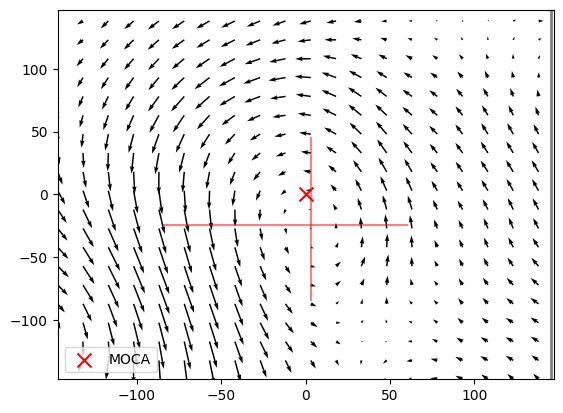

In [9]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 0, 20

vis(eddy, t, depth_lvl)

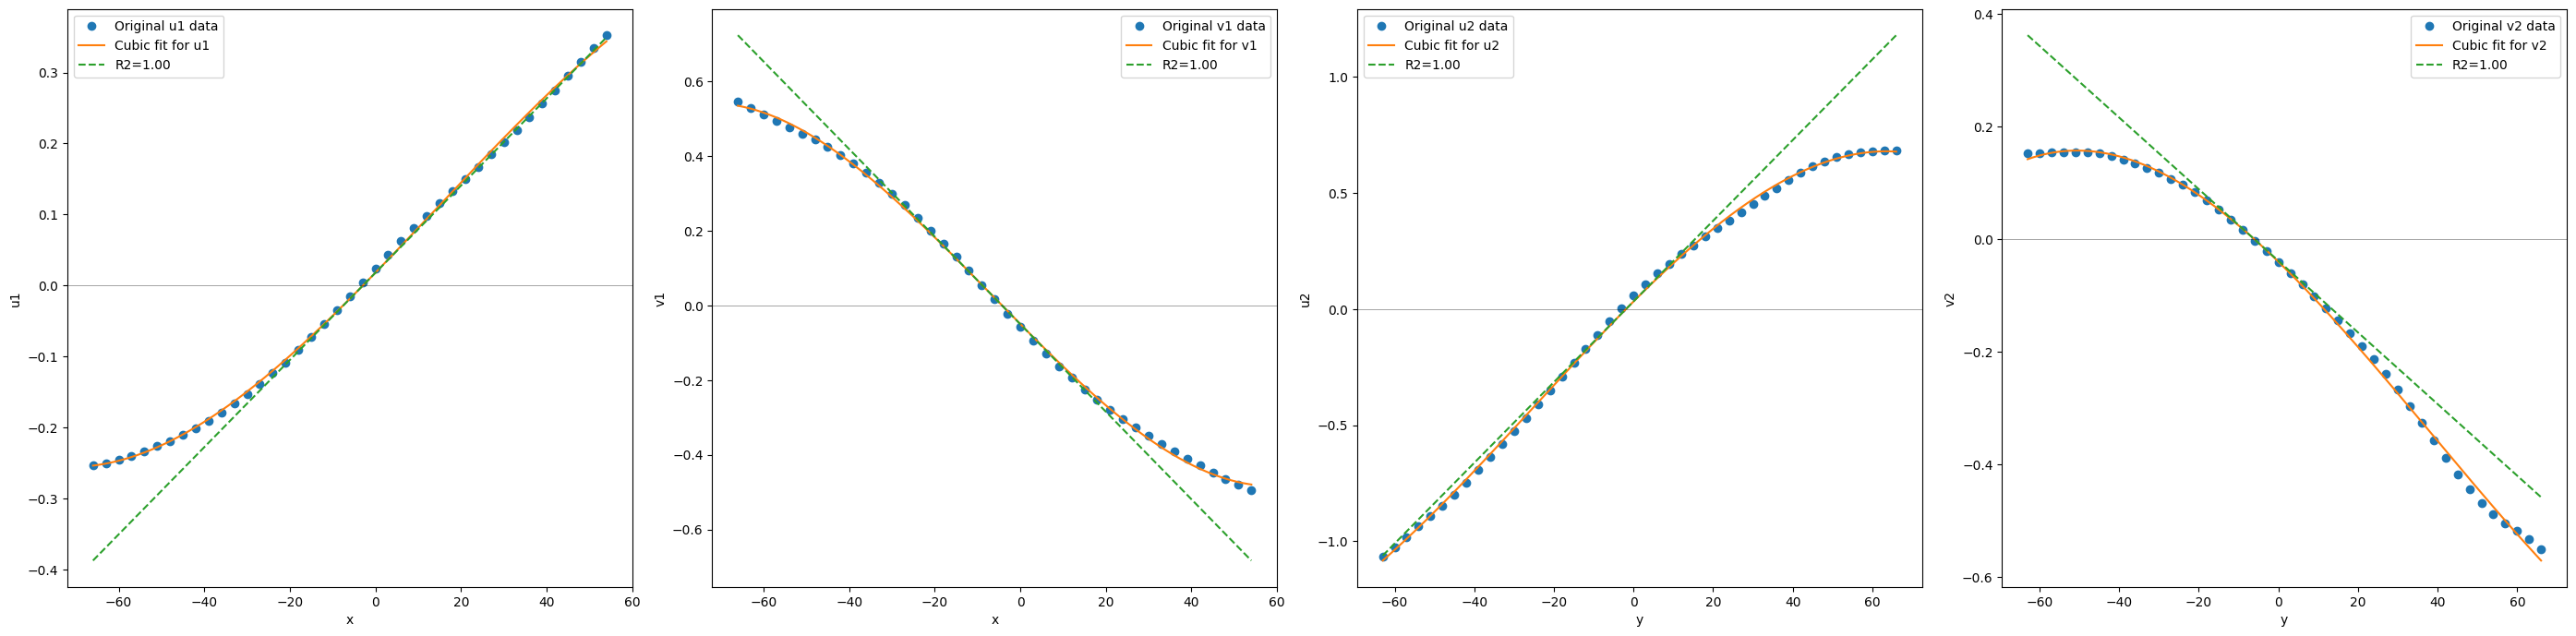

r1=63.0km, r2=60.0km, r3=60.0km, r4=72.0km


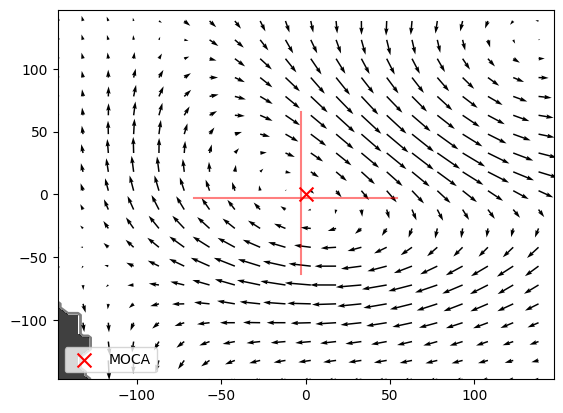

In [10]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 0, 0

vis(eddy, t, depth_lvl)

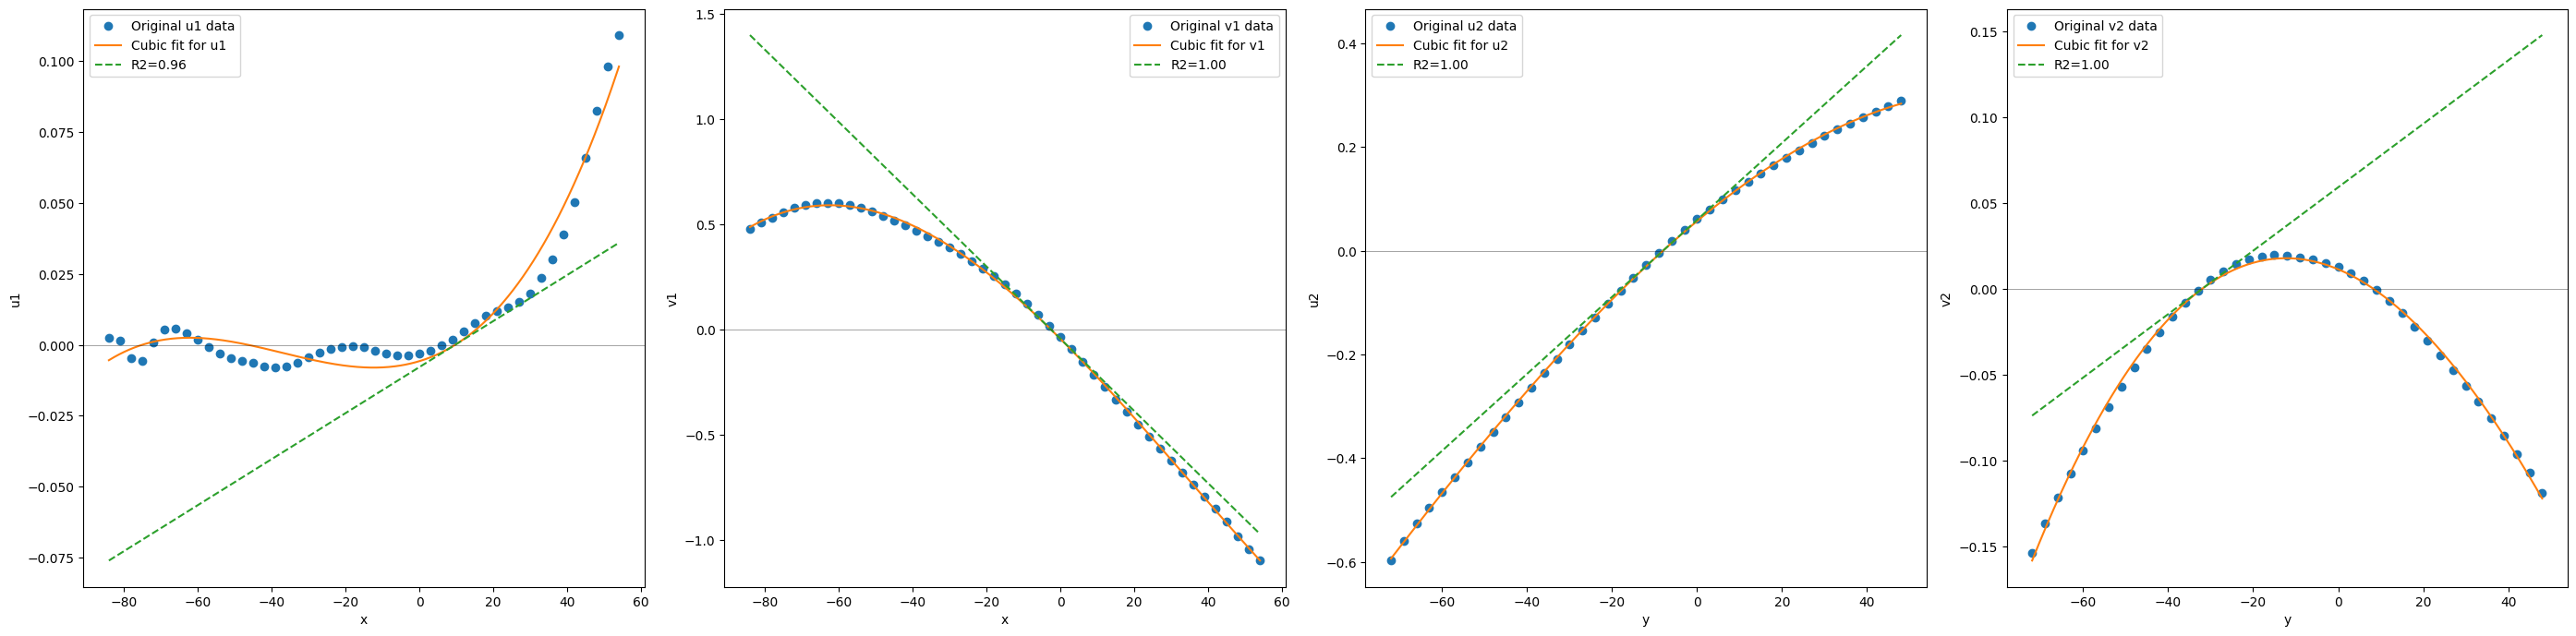

r1=81.0km, r2=60.0km, r3=63.0km, r4=60.0km


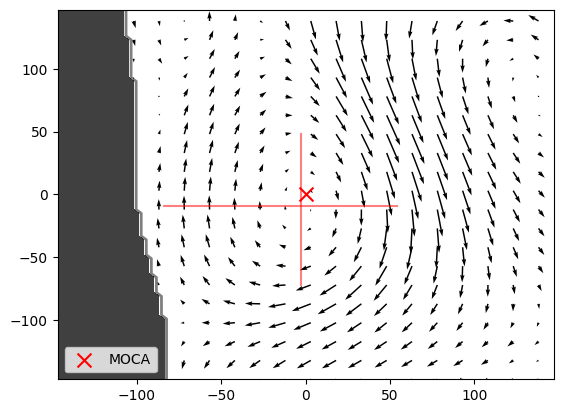

In [11]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 10, 10

vis(eddy, t, depth_lvl)

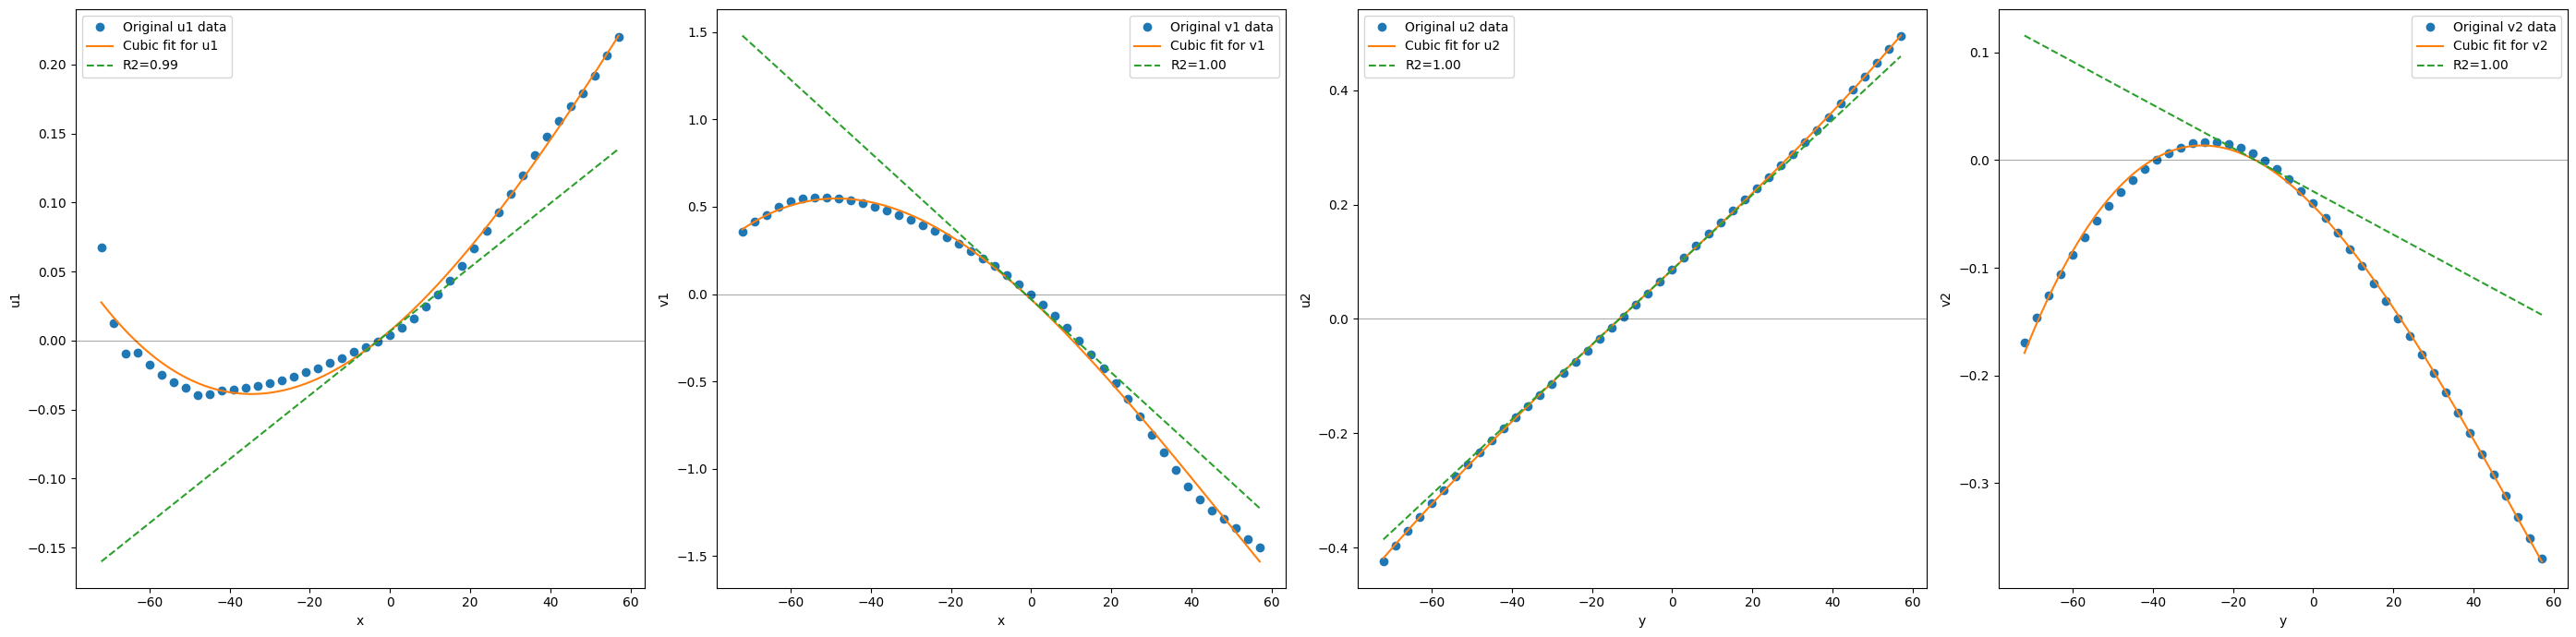

r1=72.0km, r2=60.0km, r3=60.0km, r4=72.0km


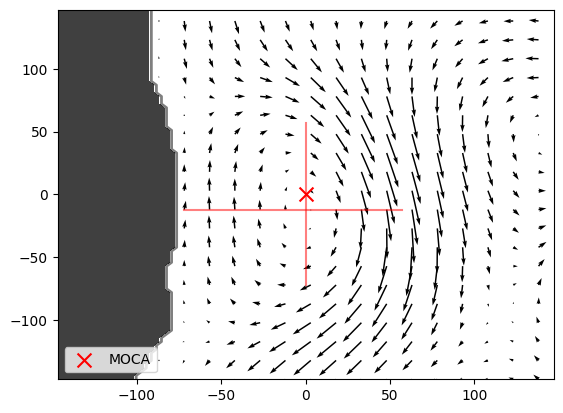

In [12]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 20, 10

vis(eddy, t, depth_lvl)

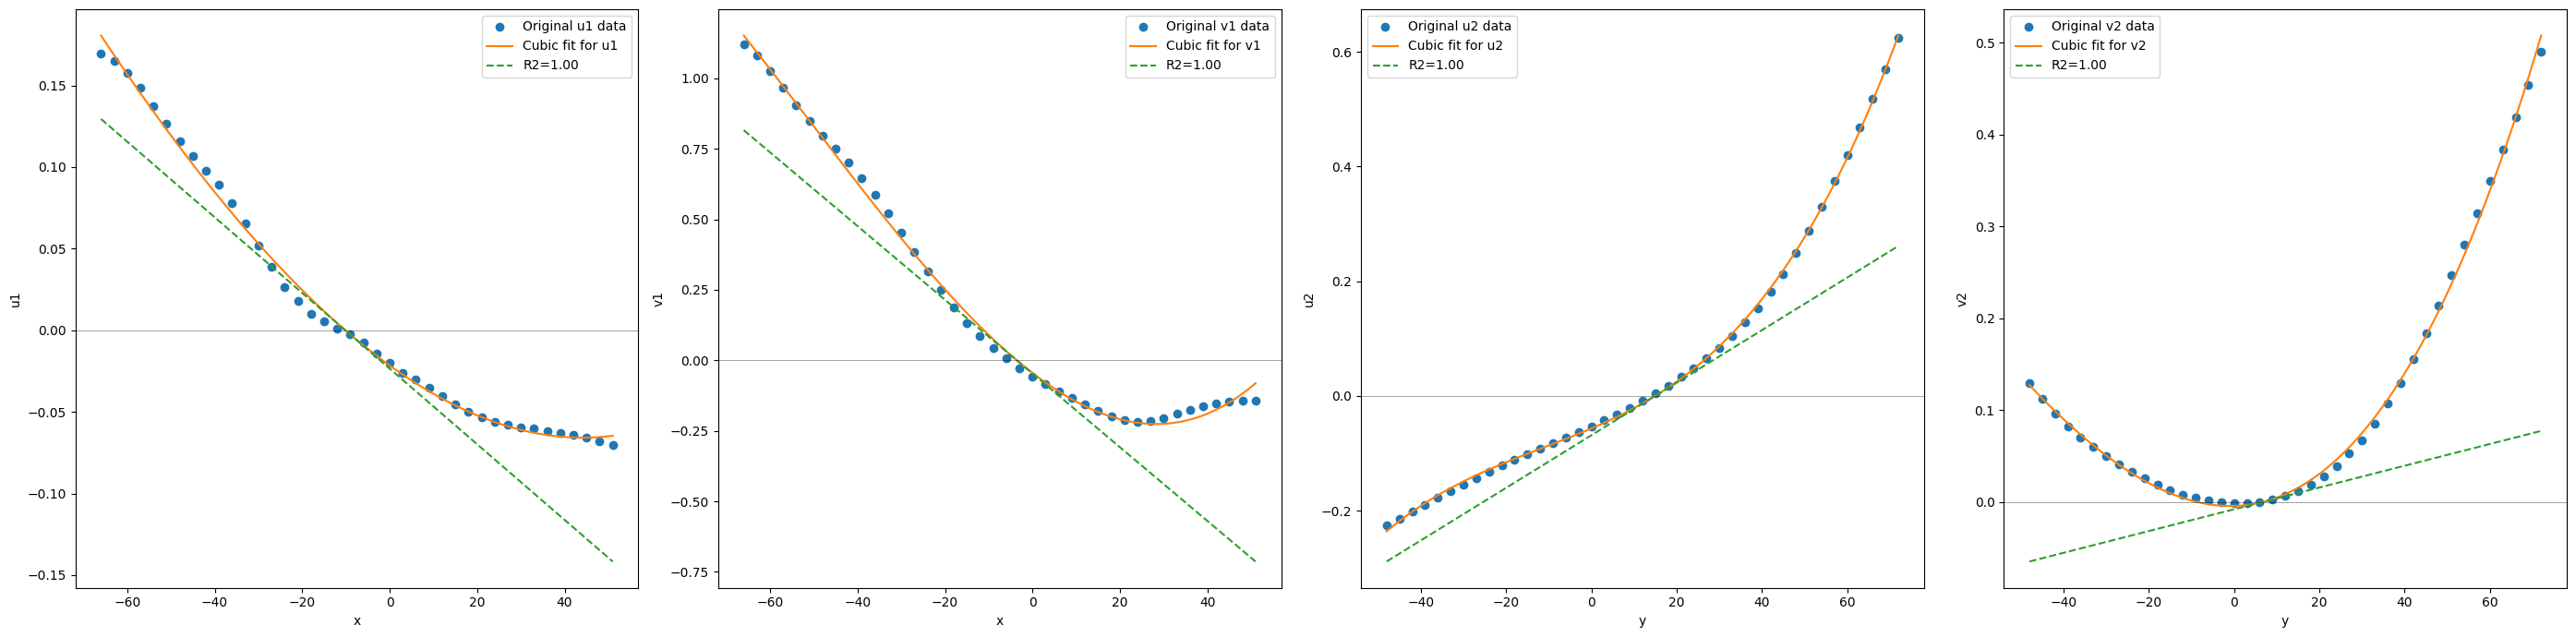

r1=60.0km, r2=60.0km, r3=60.0km, r4=63.0km


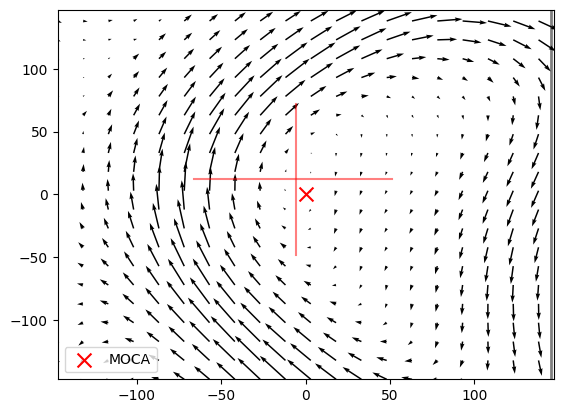

In [13]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 0, 10

vis(eddy, t, depth_lvl)

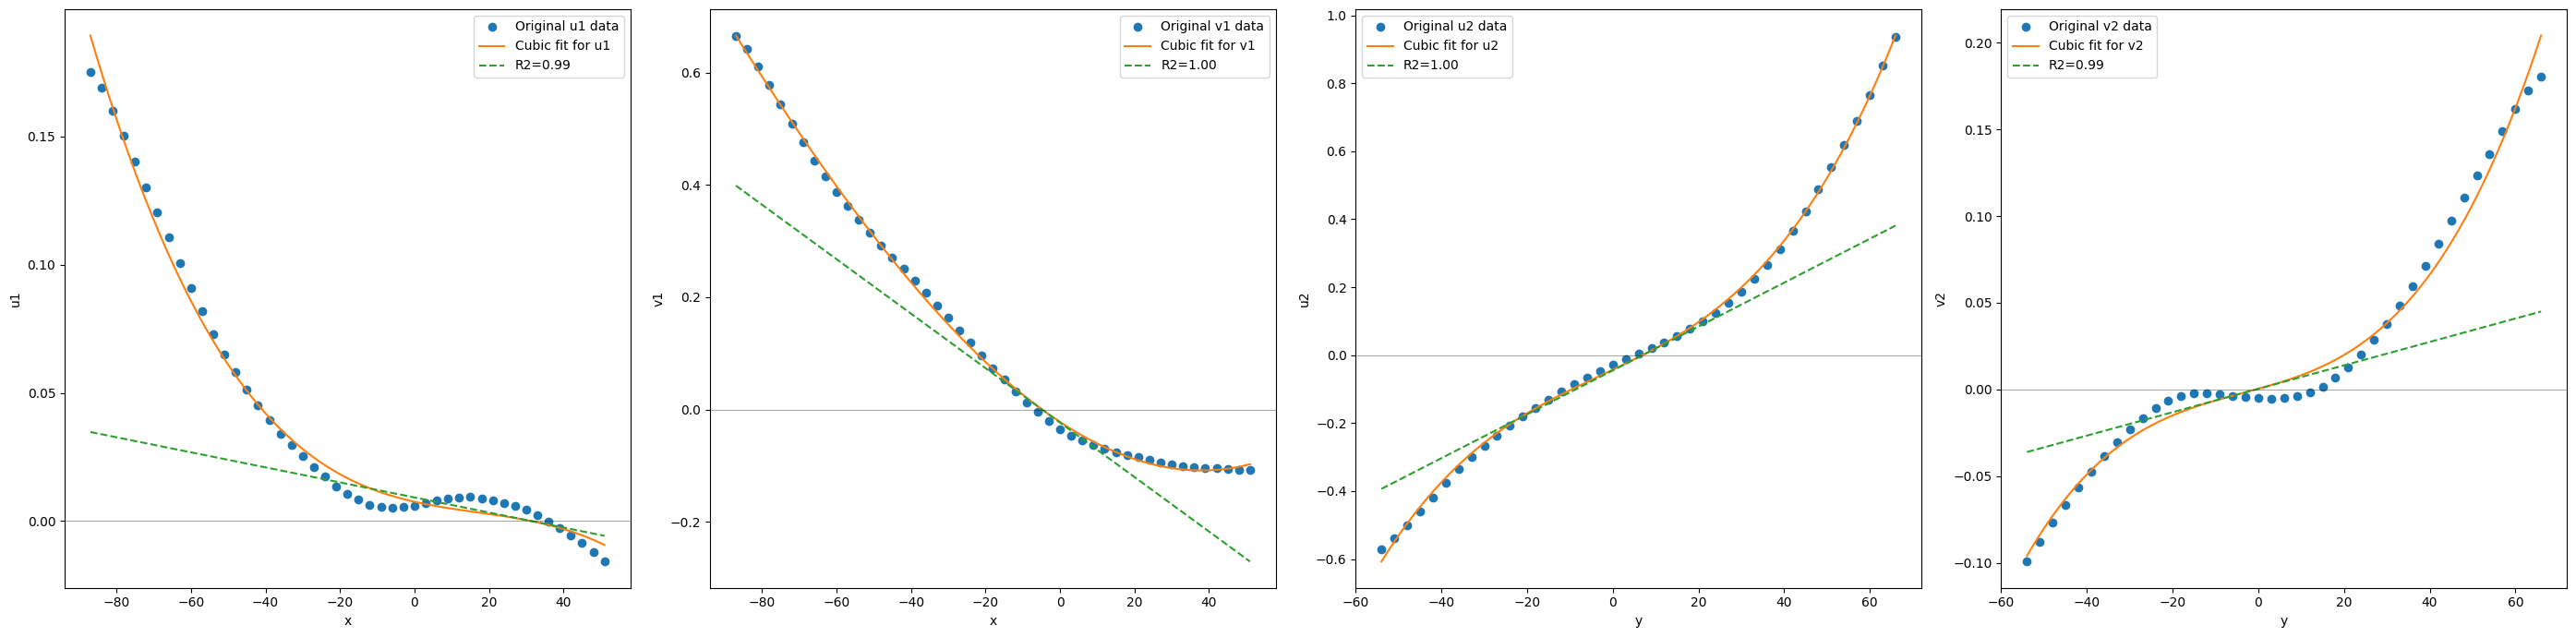

r1=81.0km, r2=60.0km, r3=60.0km, r4=63.0km


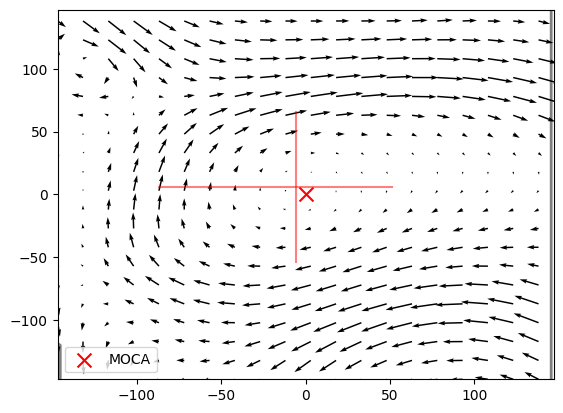

In [14]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 20, 10

vis(eddy, t, depth_lvl)

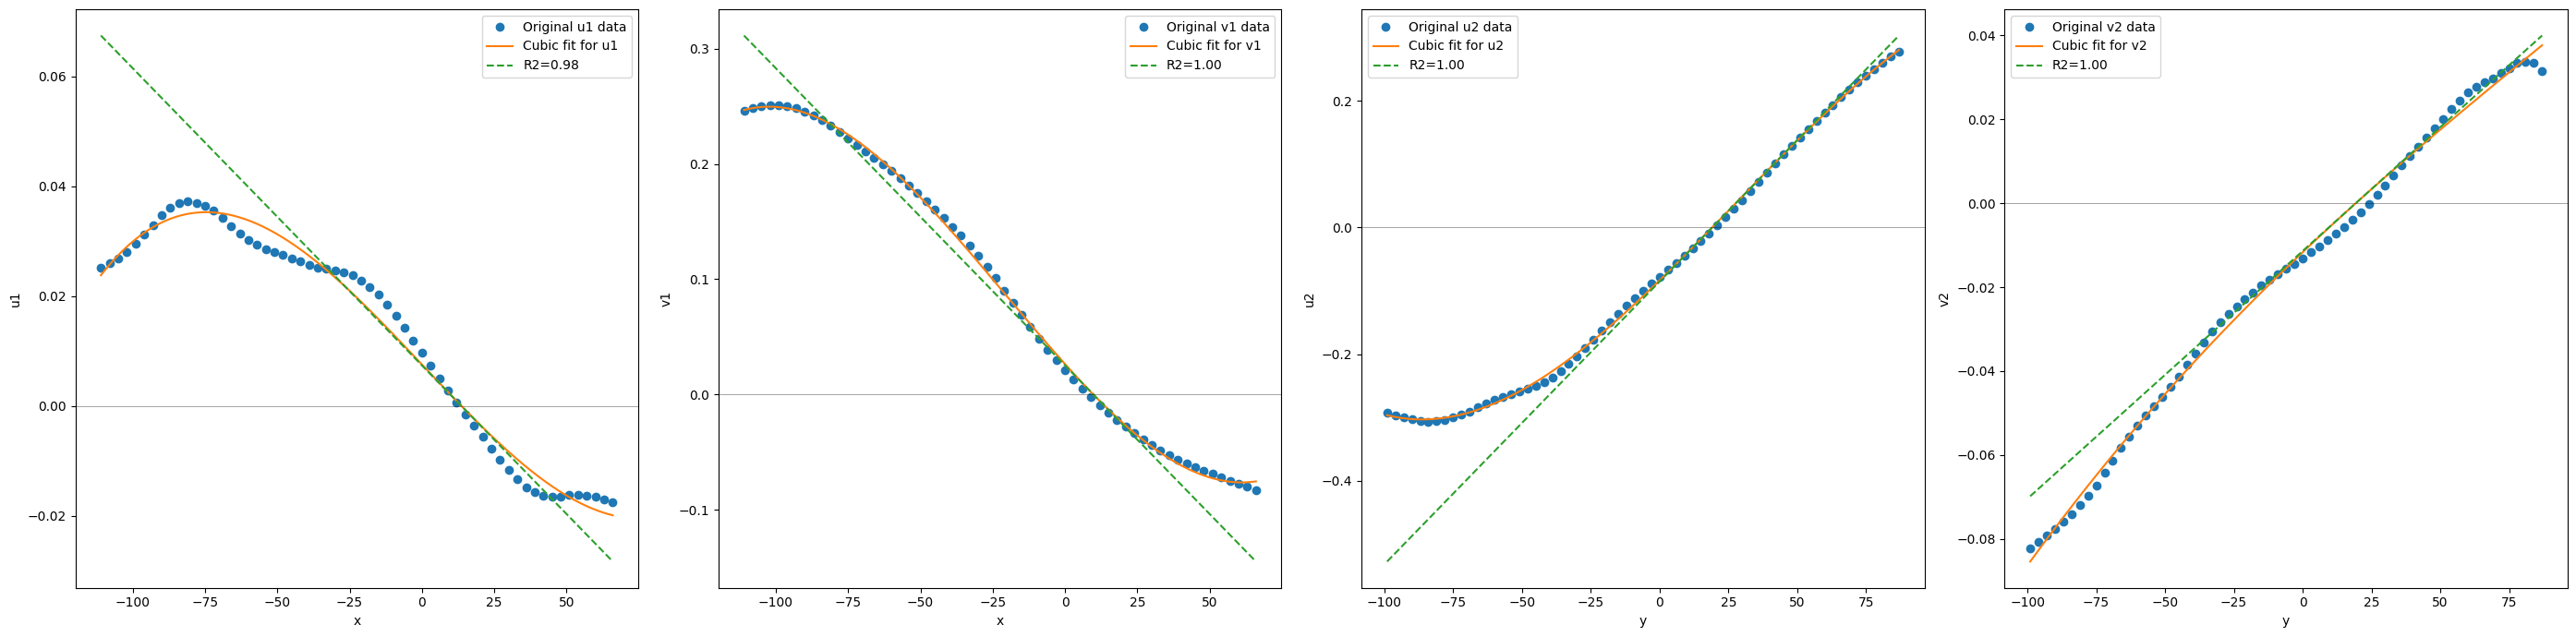

r1=120.0km, r2=60.0km, r3=120.0km, r4=69.0km


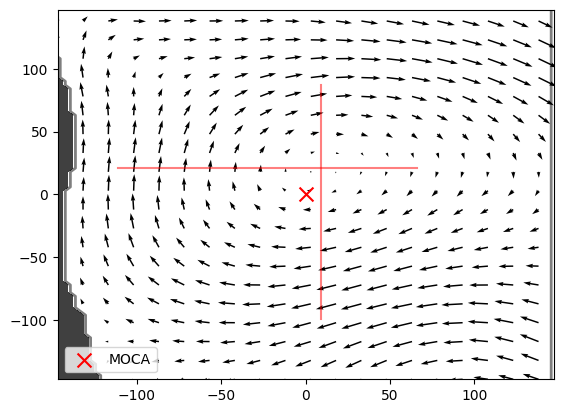

In [15]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 20, 20

vis(eddy, t, depth_lvl)

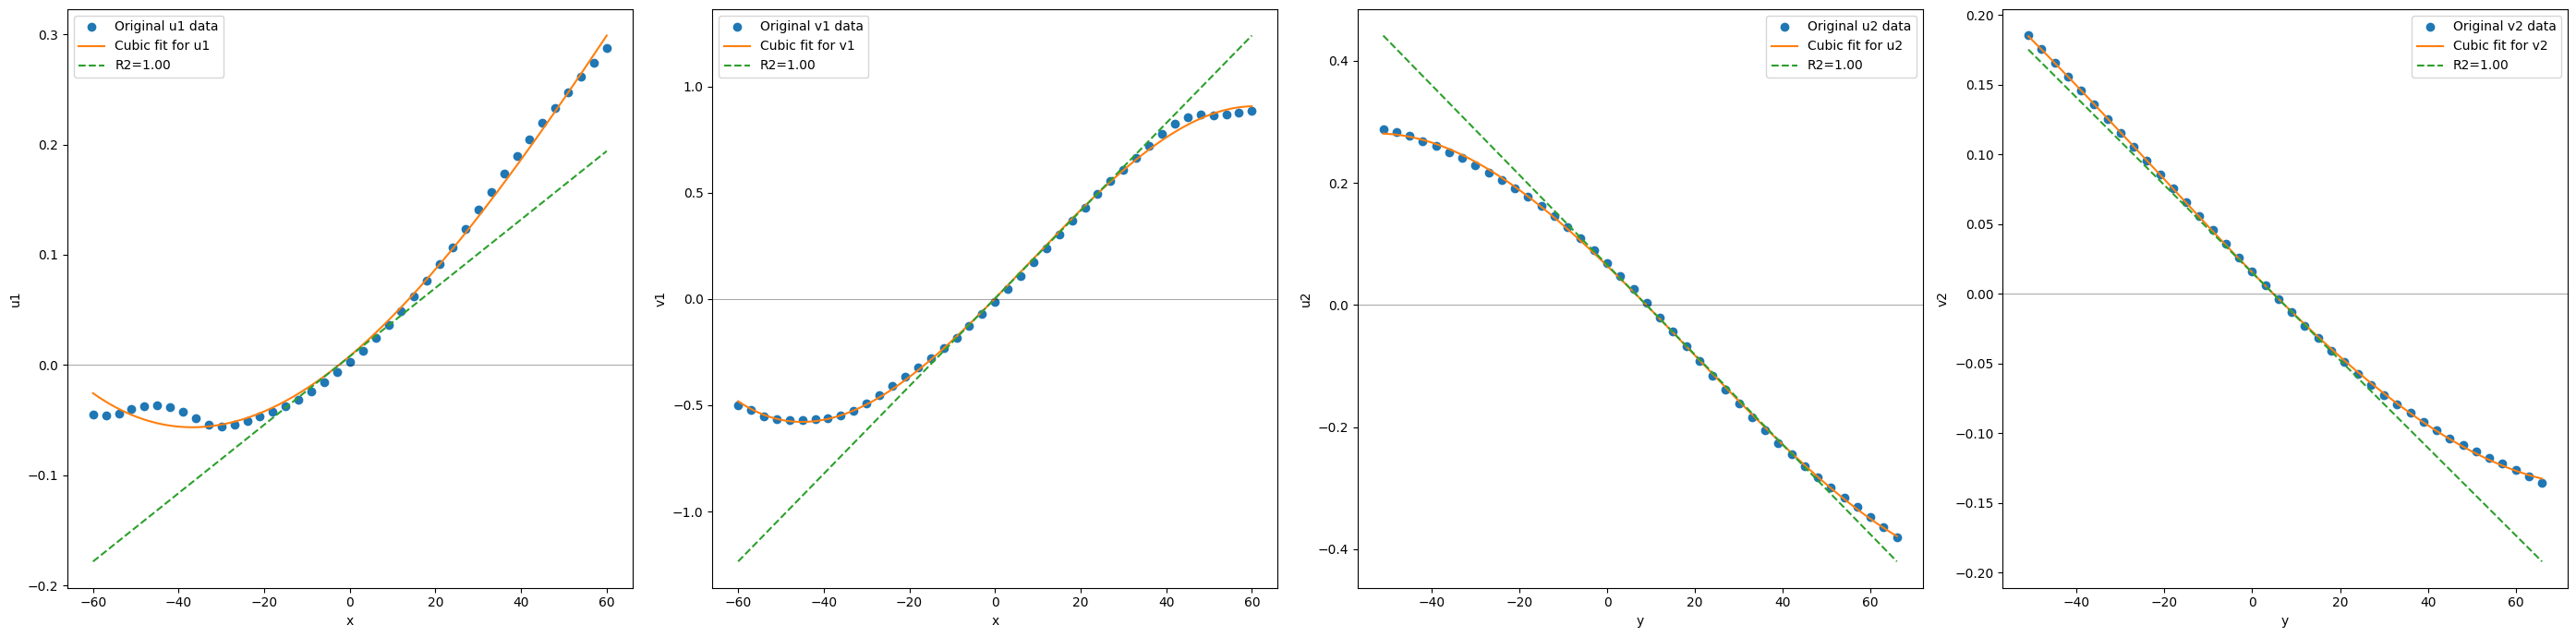

r1=60.0km, r2=63.0km, r3=60.0km, r4=60.0km


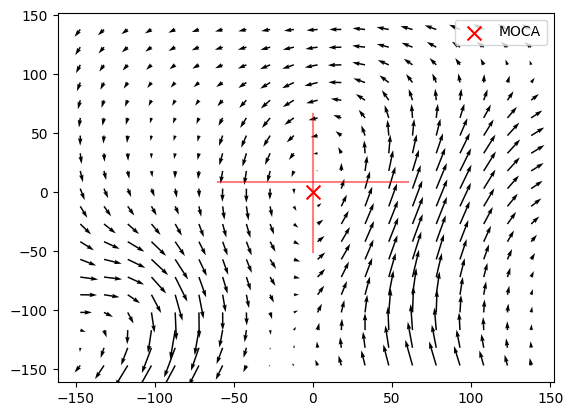

In [16]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 20, 10

vis(eddy, t, depth_lvl)

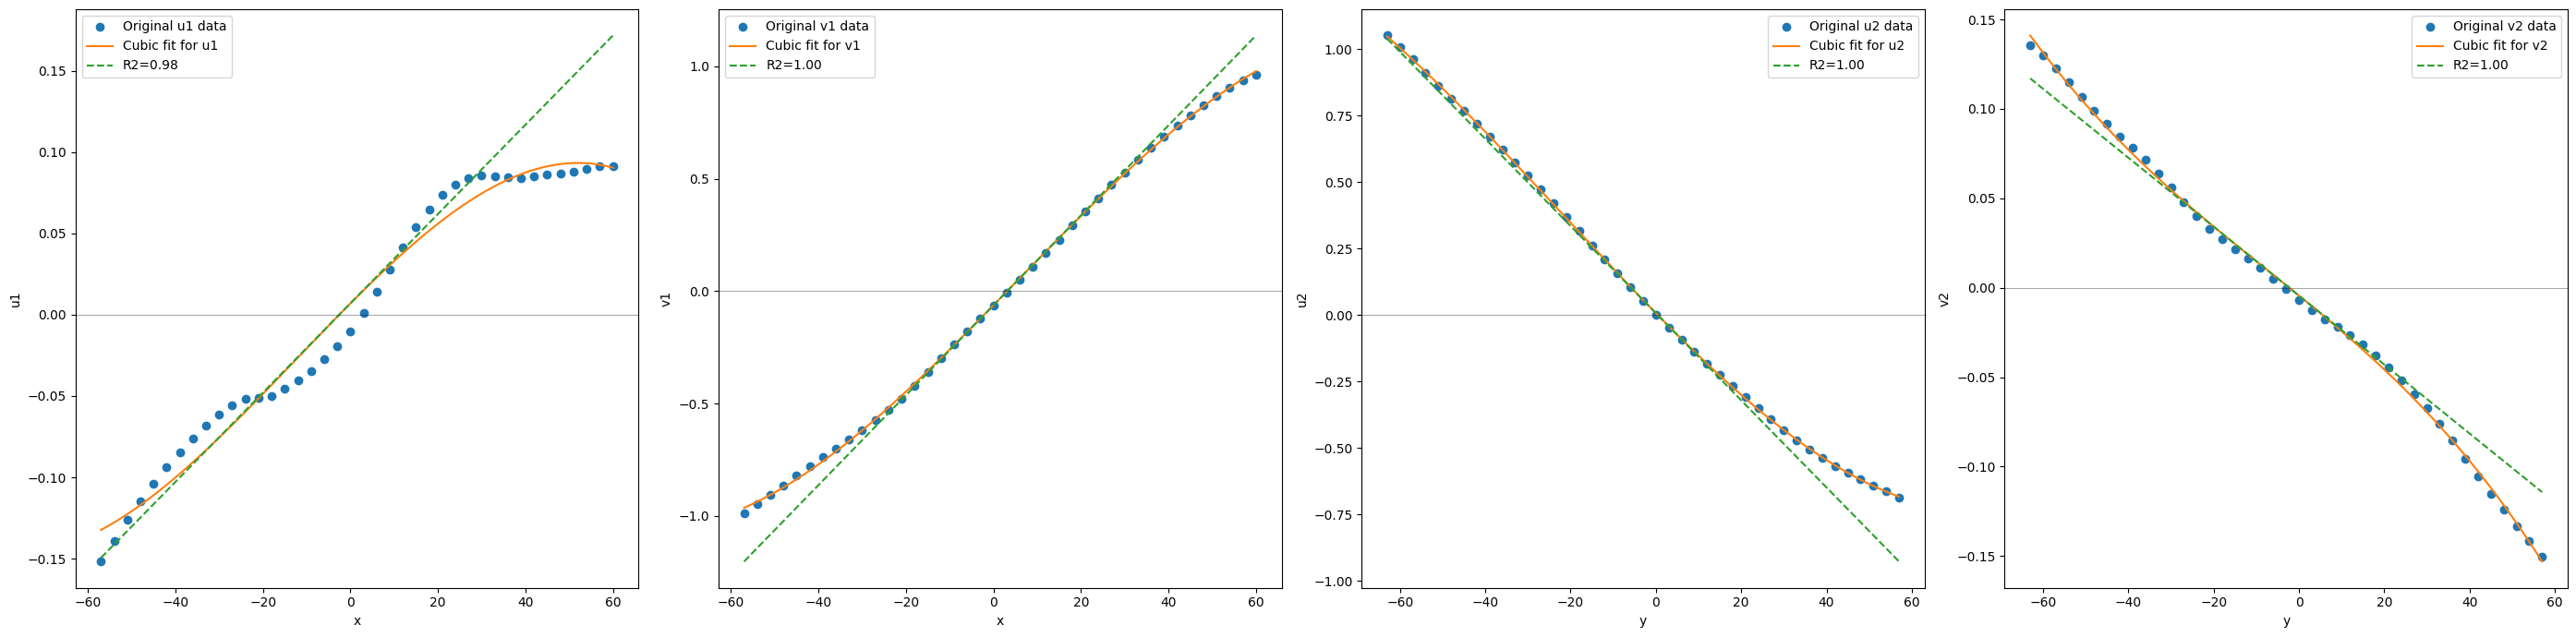

r1=60.0km, r2=60.0km, r3=63.0km, r4=60.0km


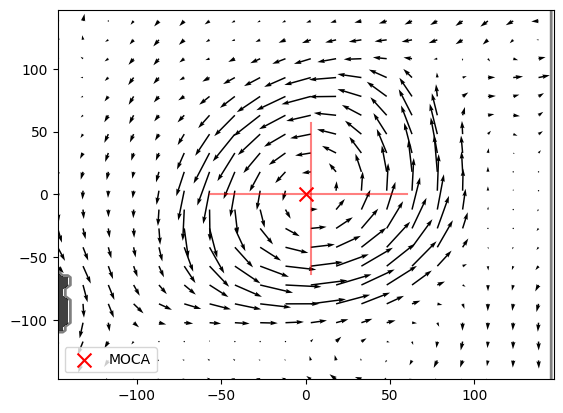

In [17]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 0, 7

vis(eddy, t, depth_lvl)

In [18]:

result_data = pd.DataFrame(columns=['Eddy', 'Day', 'z', 'nic', 'njc', 'nxc', 'nyc', 'xc', 'yc', 'Depth', 'Vort', 'r1', 'r2', 'r3', 'r4'])

plot_data = {}

for eddy in the_frontier_eddies:

    plot_data[eddy] = {}
    U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']
    X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
    var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
    xc_pre, yc_pre = 0, 0

    for depth_lvl in range(U.shape[-1]):

        # Find nencioli
        u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
        neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
        neddy = neddy[neddy[:, 2] == var]
        
        if len(neddy[:, 1]) > 1:
            R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
            neddy = neddy[R == np.nanmin(R)]
        elif len(neddy[:, 1]) == 0:
            break
        
        nxc, nyc = neddy[0, 1], neddy[0, 0]
        nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]
        
        # Fit cubic and tangent
        def fit_cubic_and_tangent(x, y):
            cubic = np.poly1d(np.polyfit(x, y, 3))
            cubic_deriv = np.polyder(cubic)
            roots = np.roots(cubic)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
        
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)][0]
                slope = cubic_deriv(root)
                intercept = -slope * root
            else:
                slope = 0
                roots = np.roots(cubic_deriv)
                valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
                if valid_roots.size:
                    R = np.abs(valid_roots-x[len(x)//2])
                    root = valid_roots[R==np.min(R)]
                    intercept = cubic(root)
                else:
                    intercept = np.mean(y)
    
            sst = np.sum((y - np.mean(y))**2)
            sse = np.sum((y - cubic(x))**2)  # Use cubic(x) instead of tangent_line
            r_squared = 1 if (sst == 0 and sse == 0) else 1 - (sse / sst)
                
            return slope, intercept, r_squared

        def optimal_cubic_domain(l, vel, ic, r_min=20, r_max=40):

            def min_distance_from_index_to_nan_1d(arr, ic):
                from scipy.ndimage import distance_transform_edt
                mask = np.isnan(arr)
                distances = distance_transform_edt(~mask)
                return distances[ic] - 1
                
            r_compulsory_min = min_distance_from_index_to_nan_1d(vel, ic)

            if r_compulsory_min < r_min:
                return None, None, None, None, None

            results = []
        
            for r1 in range(r_min, r_max + 1):
                for r2 in range(r_min, r_max + 1):
                    i_min, i_max = max(0, ic - r1), min(len(vel), ic + r2 + 1)
        
                    vel_cut = vel[i_min:i_max]
                    l_cut = l[i_min:i_max]
                    if np.any(np.isnan(vel_cut)): # another r will work
                        E1, E0, r2E = np.nan, np.nan, np.nan
                    else:
                        mask = ~np.isnan(vel_cut)
                        vel_cut = vel_cut[mask]
                        l_cut = l_cut[mask] / 1000
    
                        E1, E0, r2E = fit_cubic_and_tangent(l_cut, vel_cut)
            
                    results.append((r1, r2, E1, E0, r2E))
        
            df = pd.DataFrame(results, columns=['r1', 'r2', 'Slope', 'Int', 'R2'])

            if df.isna().all().all():
                return None, None, None, None, None
        
            optimal_domain = df.loc[df['R2']==np.nanmax(df['R2'])].iloc[-1]

            return optimal_domain['Slope'], optimal_domain['Int'], optimal_domain['R2'], optimal_domain['r1'], optimal_domain['r2']

        u1, v1 = u[:, njc], v[:, njc]
        u2, v2 = u[nic, :], v[nic, :]

        B1, B0, r2B, r1, r2 = optimal_cubic_domain(x, v1, nic)
        if B1 == None:
            break
        C1, C0, r2C, r3, r4 = optimal_cubic_domain(y, u2, njc)
        if C1 == None:
            break

        i_min, i_max = int(max(0, nic - r1)), int(min(len(u1), nic + r2))
        u1, v1 = u1[i_min:i_max], v1[i_min:i_max]
        xx = x[i_min:i_max]/1000
        A1, A0, r2A = fit_cubic_and_tangent(xx, u1)

        j_min, j_max = int(max(0, njc - r3)), int(min(len(u2), njc + r4))
        u2, v2 = u2[j_min:j_max], v2[j_min:j_max]
        yy = y[j_min:j_max]/1000
        D1, D0, r2D = fit_cubic_and_tangent(yy, v2)

        alpha = A0 if r2A < r2B else C0
        beta = B0 if r2B < r2D else D0
        gamma = A1 if r2A < r2D else -D1
        q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                    
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
        w = 2 * (q11 + q22)

        VORT_THRESH = 0.003
        R = np.hypot(xc - xc_pre, yc - yc_pre)
        if np.abs(w) > VORT_THRESH and R < 100:
            result_data.loc[len(result_data)] = {
                'Eddy': eddy,
                'Day': t,
                'z': depth_lvl,
                'nic': nic,
                'njc': njc,
                'nxc': nxc/1000,
                'nyc': nyc/1000,
                'xc': xc,
                'yc': yc,
                'Depth': z_r[150,150,depth_lvl],
                'Vort': w,
                'r1': r1,
                'r2': r2,
                'r3': r3,
                'r4': r4
            }
            xc_pre, yc_pre = xc, yc
            plot_data[eddy][f'x{depth_lvl}'] = xx
            plot_data[eddy][f'y{depth_lvl}'] = yy
            plot_data[eddy][f'u1_{depth_lvl}'] = u1
            plot_data[eddy][f'u2_{depth_lvl}'] = u2
            plot_data[eddy][f'v1_{depth_lvl}'] = v1
            plot_data[eddy][f'v2_{depth_lvl}'] = v2
        else:
            break

In [19]:
result_data

,Eddy,Day,z,nic,njc,nxc,nyc,xc,yc,Depth,Vort,r1,r2,r3,r4
0,Eddy790,0,0,51,49,6.0,0.0,0.837677,-1.241803,-1.783320,0.037129,20.0,23.0,22.0,20.0
1,Eddy790,0,1,51,49,6.0,0.0,0.12764,-0.212262,-5.879627,0.036935,20.0,23.0,22.0,20.0
2,Eddy790,0,2,51,49,6.0,0.0,-0.396524,0.239,-10.725783,0.036814,20.0,23.0,22.0,20.0
3,Eddy790,0,3,51,49,6.0,0.0,-0.985347,0.471723,-16.383097,0.036732,20.0,23.0,22.0,20.0
4,Eddy790,0,4,50,49,3.0,0.0,1.468657,1.179209,-22.925581,0.036457,22.0,20.0,22.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Eddy775,0,23,42,66,-21.0,51.0,-8.604607,4.969891,-1492.971178,-0.004444,20.0,40.0,28.0,20.0
101,Eddy775,0,24,36,68,-39.0,57.0,-35.743886,2.226026,-1971.212518,-0.004773,40.0,40.0,20.0,20.0
102,Eddy775,0,25,34,69,-45.0,60.0,-53.540168,-0.928622,-2568.677466,-0.005046,31.0,25.0,26.0,20.0
103,Eddy775,0,26,33,70,-48.0,63.0,-54.558694,0.220692,-3252.716389,-0.006179,20.0,20.0,27.0,20.0


In [20]:
t = 0
filtered_data = result_data[(result_data['Eddy'] == 'Eddy790') & (result_data['Day'] == t)].drop(columns=['Eddy', 'Day']).set_index('z')
filtered_data


,nic,njc,nxc,nyc,xc,yc,Depth,Vort,r1,r2,r3,r4
z,,,,,,,,,,,,
0,51,49,6.0,0.0,0.837677,-1.241803,-1.783320,0.037129,20.0,23.0,22.0,20.0
1,51,49,6.0,0.0,0.12764,-0.212262,-5.879627,0.036935,20.0,23.0,22.0,20.0
2,51,49,6.0,0.0,-0.396524,0.239,-10.725783,0.036814,20.0,23.0,22.0,20.0
3,51,49,6.0,0.0,-0.985347,0.471723,-16.383097,0.036732,20.0,23.0,22.0,20.0
4,50,49,3.0,0.0,1.468657,1.179209,-22.925581,0.036457,22.0,20.0,22.0,20.0
5,50,49,3.0,0.0,0.905503,0.943472,-30.444118,0.036457,20.0,20.0,22.0,20.0
6,50,49,3.0,0.0,0.524849,0.713281,-39.052712,0.036413,20.0,20.0,21.0,20.0
7,50,49,3.0,0.0,0.284453,0.472327,-48.897638,0.036418,20.0,20.0,21.0,20.0
8,50,49,3.0,0.0,0.132895,0.286111,-60.170639,0.036470,20.0,26.0,22.0,20.0


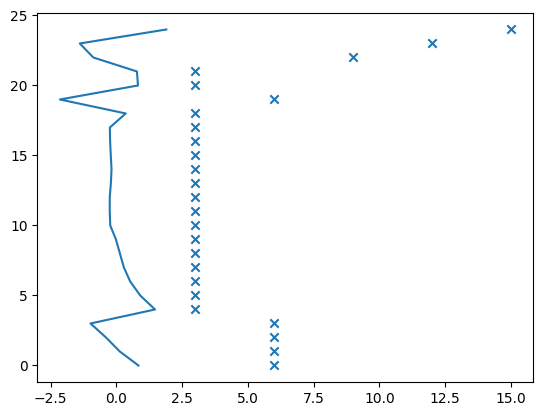

In [21]:
plt.scatter(filtered_data['nxc'], filtered_data.index, marker='x')
plt.plot(filtered_data['xc'], filtered_data.index)

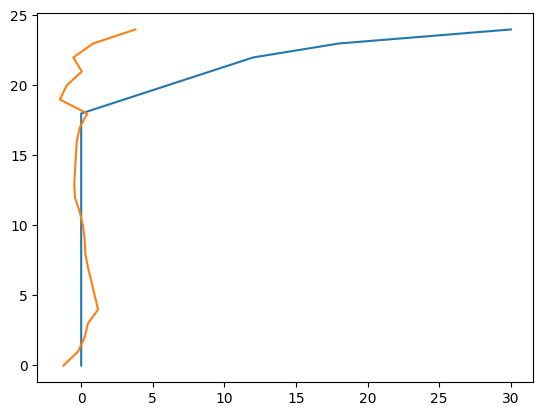

In [22]:
plt.plot(filtered_data['nyc'], filtered_data.index)
plt.plot(filtered_data['yc'], filtered_data.index)

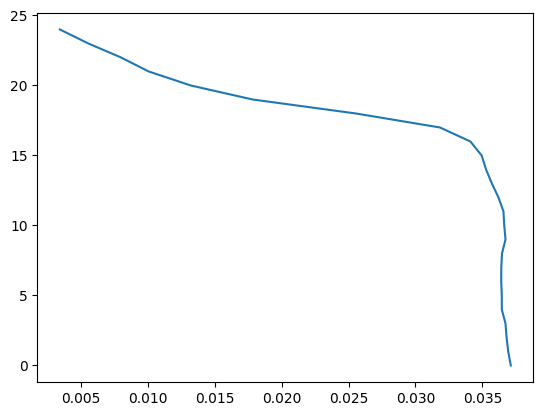

In [23]:
plt.plot(filtered_data['Vort'], filtered_data.index)

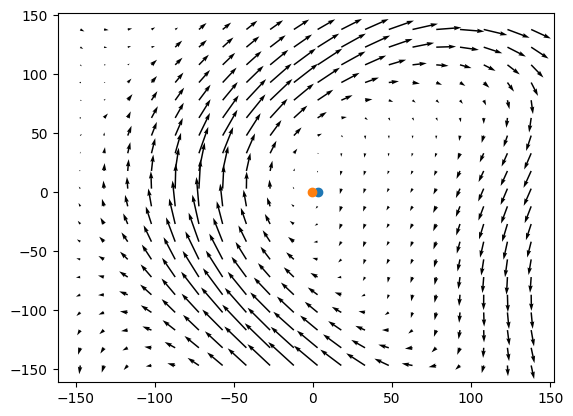

In [24]:
U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']

depth_lvl = 10

u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]

data = filtered_data.loc[depth_lvl]

spacing = 5
plt.quiver(x[::spacing]/1000, y[::spacing]/1000, u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)
plt.scatter(data['nxc'], data['nyc'])
plt.scatter(data['xc'], data['yc'])

In [25]:
filtered_data

,nic,njc,nxc,nyc,xc,yc,Depth,Vort,r1,r2,r3,r4
z,,,,,,,,,,,,
0,51,49,6.0,0.0,0.837677,-1.241803,-1.783320,0.037129,20.0,23.0,22.0,20.0
1,51,49,6.0,0.0,0.12764,-0.212262,-5.879627,0.036935,20.0,23.0,22.0,20.0
2,51,49,6.0,0.0,-0.396524,0.239,-10.725783,0.036814,20.0,23.0,22.0,20.0
3,51,49,6.0,0.0,-0.985347,0.471723,-16.383097,0.036732,20.0,23.0,22.0,20.0
4,50,49,3.0,0.0,1.468657,1.179209,-22.925581,0.036457,22.0,20.0,22.0,20.0
5,50,49,3.0,0.0,0.905503,0.943472,-30.444118,0.036457,20.0,20.0,22.0,20.0
6,50,49,3.0,0.0,0.524849,0.713281,-39.052712,0.036413,20.0,20.0,21.0,20.0
7,50,49,3.0,0.0,0.284453,0.472327,-48.897638,0.036418,20.0,20.0,21.0,20.0
8,50,49,3.0,0.0,0.132895,0.286111,-60.170639,0.036470,20.0,26.0,22.0,20.0
